# Import libraries

In [1]:
import torch
import tensorboard

TORCH_VERSION = torch.__version__.split("+")[0]
CUDA_VERSION = torch.__version__.split("+")[1]
print(f"PyTorch: {TORCH_VERSION}; CUDA: {CUDA_VERSION}")

PyTorch: 1.10.2; CUDA: cu113


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [3]:
import os, random, json
import cv2

from matplotlib import pyplot as plt

from detectron2 import model_zoo

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor

from detectron2.utils.visualizer import Visualizer, ColorMode
import detectron2.data.detection_utils as utils

In [4]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

In [5]:
os.getcwd()

'/srv/data/shared/dev/notebooks'

In [6]:
DATA_PATH = os.environ['DATA_PATH']
DATASET_PATH = os.path.abspath(os.path.join(DATA_PATH, 'detection_datasets/jpn_parking'))
TILES_PATH = os.path.abspath(os.path.join(DATA_PATH, 'tiles'))
MODELS_PATH = os.path.abspath(os.path.join(os.getcwd(), '../models/'))

print(f"Current path : {os.getcwd()}")
print(f"Data path    : {DATA_PATH}")
print(f"Tiles path   : {TILES_PATH}")
print(f"Dataset path : {DATASET_PATH}")
print(f"Models path  : {MODELS_PATH}")

Current path : /srv/data/shared/dev/notebooks
Data path    : /srv/data/shared/dev/data/
Tiles path   : /srv/data/shared/dev/data/tiles
Dataset path : /srv/data/shared/dev/data/detection_datasets/jpn_parking
Models path  : /srv/data/shared/dev/models


# Load data

In [7]:
import pandas as pd
import numpy as np
from detectron2.data.detection_utils import read_image

import cv2

from lib.gdf_from_csv import gdf_from_csv

import math

def square_image(image):
    _height, _width = image.shape[:2]
    if _height > _width:
        image = np.rot90(image)
        _height, _width = _width, _height
    shape = [_width, _width, *image.shape[2:]]
    result = np.zeros(shape)    
    idx = math.ceil((_width-_height)/2)
    result[idx:idx+_height] = image
    result = result.astype(np.uint8)
    return result

def read_parking():
    parking = gdf_from_csv(os.path.join(DATA_PATH, "parking.csv")).fillna('None')
    parking.set_index('id', inplace=True)
    parking.geom = parking.simplify(0.00001)
    return parking

def read_data():
    # Init dataset
    X = []
    y = []
    
    # Read prediction logs
    path = os.path.abspath(os.path.join(DATA_PATH, "recognition/pred_logs.csv"))
    pred_logs = pd.read_csv(path) \
        .set_index('feature_id').dropna(subset=['line_style_0', 'line_style_2'])
    
    parking = read_parking()
    
    mask = pd.DataFrame([
        parking['country'].isin({'USA'}),
        # parking['surface_type'].isin({'Asphalt', 'Concrete'}),
    ]).all()
    
    # Iterate over feature records
    for feature_id in parking.index[mask]:
        # Get 'line_style' label
        label = parking.loc[feature_id, 'surface_type']
        
        try:
            # Read space image RGB
            image_rgb_path = os.path.abspath(os.path.join(
                DATA_PATH, 
                f"recognition/features/{feature_id}/image_rgb.png",
            ))
            image_rgb = utils.read_image(image_rgb_path)
            
            # Read sideline image
            # pred_mask_path = os.path.abspath(os.path.join(
            #     DATA_PATH, 
            #     f"recognition/features/{feature_id}/pred_mask.png",
            # ))
            # pred_mask = utils.read_image(pred_mask_path)
        except:
            continue
            
        image = cv2.resize(square_image(image_rgb), (32, 32), interpolation=cv2.INTER_AREA)
            
        # Save feature to dataset
        X.append(image)
        y.append(label)
        
        # Augment if rare feature
        if label in {'Soil', 'Brick'}:
            for i in range(3):
                X.append(np.rot90(image.copy(), k=i+1))
                y.append(label)
                    
    # Extract classes
    classes = np.unique(y).tolist()
    y = np.array([classes.index(i) for i in y])                
    return np.array(X), np.array(y), np.array(classes)

X, y , class_names = read_data()
# print(X.shape, y.shape)
print('number of samples: ', X.shape[0])
print('\nimage shape:\n', X[0].shape, sep='')
print('\nlabels:\n', pd.Series(y).map(class_names.take).value_counts(), sep='')

number of samples:  21460

image shape:
(32, 32, 3)

labels:
Asphalt     17108
Concrete     3760
Soil          464
Brick         128
dtype: int64


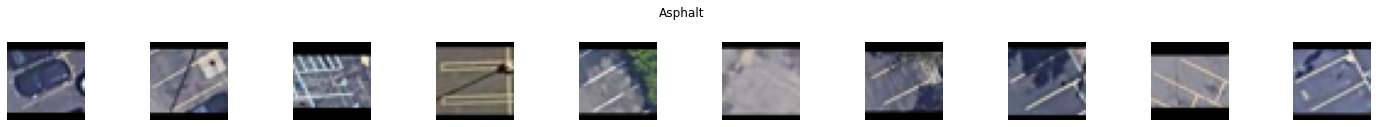

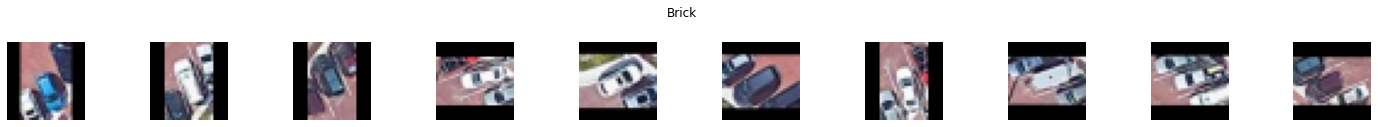

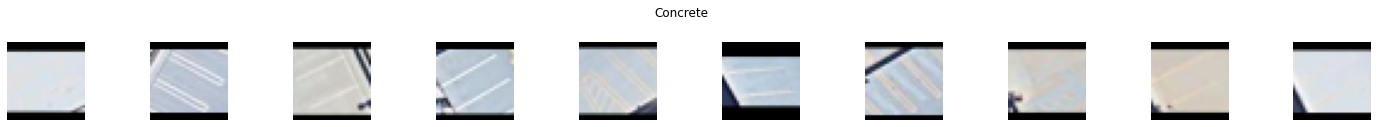

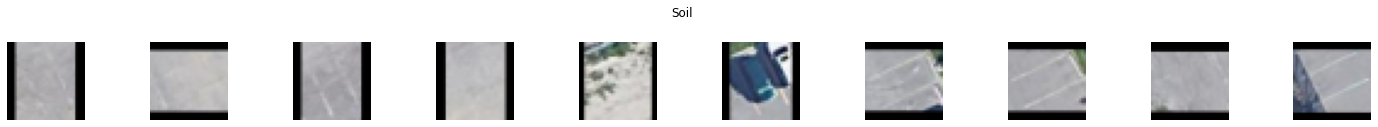

In [8]:
import random

for label in np.unique(y):
    # set up the matplotlib figure and axes, based on the number of labels
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(class_names[label])
    fig.tight_layout()
    # make a plot for every label (equipment) type. The index method returns the 
    # index of the first item corresponding to its search string, label in this case
    for ax in axes:
        img = random.choice(X[y==label])
        ax.imshow(img, cmap='gray')
        ax.axis('off')

In [9]:
import torch
from torch.utils.data import Dataset

class SurfaceTypeDataset(Dataset):
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    shuffle=True,
    random_state=42,
    stratify=y,
)

In [11]:
BATCH_SIZE = 100
LEARNING_RATE = 0.001

train_data = SurfaceTypeDataset(X_train, y_train, transform=ToTensor())
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=1)

test_data = SurfaceTypeDataset(X_test, y_test, transform=ToTensor())
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=1)

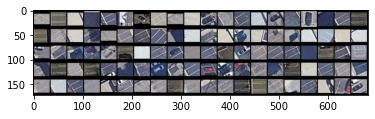

In [12]:
import torchvision

# functions to show an image
def show_batch_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
show_batch_grid(torchvision.utils.make_grid(images, nrow=20))

# Train model

In [14]:
import torch.nn as nn
from lib.recognition.surface_type_clf import SurfaceTypeClassifier

clf = SurfaceTypeClassifier(class_names=class_names)    

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf._model.parameters(), lr=LEARNING_RATE)

In [15]:
from torch.autograd import Variable
from datetime import datetime

num_epochs = 250

losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):        
        images = Variable(images.float()).to(clf._device)
        labels = Variable(labels).to(clf._device)
        
        # Forward + Backward + Optimize
        # Zero gradients have a problem. Cold start problem. start with normal distribution.
        
        optimizer.zero_grad()
        outputs = clf._model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.item());
    
    if (epoch+1)%5==0:
        ts = datetime.now().isoformat()       
        print(f'{ts}: epoch : {(epoch+1):03d}/{num_epochs:03d}, loss: {loss.data.item():.5f}')

2022-06-22T10:21:37.938784: epoch : 005/250, loss: 0.13152
2022-06-22T10:21:42.279232: epoch : 010/250, loss: 0.08884
2022-06-22T10:21:46.643846: epoch : 015/250, loss: 0.04398
2022-06-22T10:21:51.008761: epoch : 020/250, loss: 0.06852
2022-06-22T10:21:55.354439: epoch : 025/250, loss: 0.04511
2022-06-22T10:21:59.715163: epoch : 030/250, loss: 0.00741
2022-06-22T10:22:04.070347: epoch : 035/250, loss: 0.01090
2022-06-22T10:22:08.415894: epoch : 040/250, loss: 0.02865
2022-06-22T10:22:12.782385: epoch : 045/250, loss: 0.03014
2022-06-22T10:22:17.144337: epoch : 050/250, loss: 0.00783
2022-06-22T10:22:21.524211: epoch : 055/250, loss: 0.01971
2022-06-22T10:22:25.953977: epoch : 060/250, loss: 0.07475
2022-06-22T10:22:30.307537: epoch : 065/250, loss: 0.02814
2022-06-22T10:22:34.691366: epoch : 070/250, loss: 0.00974
2022-06-22T10:22:39.067153: epoch : 075/250, loss: 0.00438
2022-06-22T10:22:43.425839: epoch : 080/250, loss: 0.03578
2022-06-22T10:22:47.810650: epoch : 085/250, loss: 0.034

<AxesSubplot:>

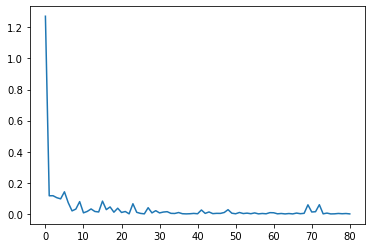

In [16]:
pd.Series(losses[::500]).plot()

# Evaluate

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [18]:
clf._model.eval()

correct = 0

test = []
pred = []

for images, labels in testloader:
    images = Variable(images.float()).to(clf._device)
    outputs = clf._model(images)
    _, predicted = torch.max(outputs.data, 1)
    # correct += (predicted == labels).sum()
    test.extend(labels)
    pred.extend(predicted.cpu())
    
test = np.array(test)
pred = np.array(pred)

accuracy = (test==pred).sum() / test.shape[0] * 100
print('Test Accuracy of the model on the 100 test images: %.4f %%' % (accuracy))

Test Accuracy of the model on the 100 test images: 98.6580 %


<AxesSubplot:>

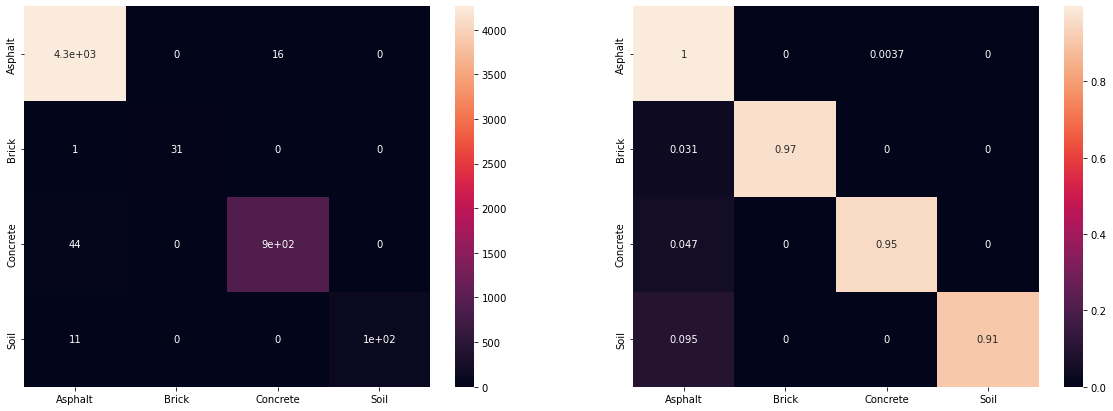

In [26]:
import seaborn as sn

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

matrix_avg = confusion_matrix(test, pred)
sn.heatmap(pd.DataFrame(matrix_avg, index=class_names, columns=class_names), ax=axes[0], annot=True)

matrix_pct = (matrix_avg.T / matrix_avg.sum(axis=1)).T
sn.heatmap(pd.DataFrame(matrix_pct, index=class_names, columns=class_names), ax=axes[1], annot=True)

In [20]:
pr = pd.DataFrame([
    precision_score(test, pred, average=None),
    recall_score(test, pred, average=None),
], columns=class_names, index=['precision', 'recall']).round(3)

pr

,Asphalt,Brick,Concrete,Soil
precision,0.987,1.000,0.982,1.000
recall,0.996,0.969,0.953,0.905


In [28]:
metrics = {
    "accuracy": accuracy_score(test, pred),
    "pr": pr.to_dict(),
    "confusion": pd.DataFrame(matrix_avg, index=class_names, columns=class_names).T.to_dict(),
}

clf.metrics = metrics

Please scecify your name:  Alexey Gribko


# Save model

In [31]:
clf._class_names = clf._class_names.tolist()

In [33]:
PATH = "../models/recognition/surface_type"
clf.save(PATH)

Folder already exists. Rewrite model at "../models/recognition/surface_type"? (Y/n): Y


Rewriting model...
Done!


In [34]:
print(PATH)
!ls $PATH

../models/recognition/surface_type
class_names.json  metrics.json	model.pth
